# Tutorial - Test 

In [2]:
import gmsh
import sys
import numpy as np
from fidelio import *
import math

## Geometría en GMSH

In [3]:
filename = "annulus.msh"
R_outer = 1.0
R_inner = 0.4
lc = 0.05

gmsh.initialize()
gmsh.model.add("annulus")

geo = gmsh.model.geo

# =====================================================
# 1) Puntos
# =====================================================
# Centro
pc = geo.addPoint(0, 0, 0, lc)

# --- Círculo exterior ---
pR  = geo.addPoint( R_outer, 0, 0, lc)
pT  = geo.addPoint(0,  R_outer, 0, lc)
pL  = geo.addPoint(-R_outer, 0, 0, lc)
pB  = geo.addPoint(0, -R_outer, 0, lc)

# --- Círculo interior ---
pRi = geo.addPoint( R_inner, 0, 0, lc)
pTi = geo.addPoint(0,  R_inner, 0, lc)
pLi = geo.addPoint(-R_inner, 0, 0, lc)
pBi = geo.addPoint(0, -R_inner, 0, lc)

# =====================================================
# 2) Arcos exteriores
# =====================================================
# Right arc (x > 0)
arc_RT = geo.addCircleArc(pR, pc, pT)
arc_TL = geo.addCircleArc(pT, pc, pL)
arc_LB = geo.addCircleArc(pL, pc, pB)
arc_BR = geo.addCircleArc(pB, pc, pR)

# Dividimos en left / right
outer_right = [arc_BR, arc_RT]
outer_left  = [arc_TL, arc_LB]

# =====================================================
# 3) Arcos interiores
# =====================================================
arc_iRT = geo.addCircleArc(pRi, pc, pTi)
arc_iTL = geo.addCircleArc(pTi, pc, pLi)
arc_iLB = geo.addCircleArc(pLi, pc, pBi)
arc_iBR = geo.addCircleArc(pBi, pc, pRi)

# Dividimos en up / down
inner_up   = [arc_iRT, arc_iTL]
inner_down = [arc_iLB, arc_iBR]

# =====================================================
# 4) Curve loops
# =====================================================
outer_loop = geo.addCurveLoop(
    outer_right + outer_left
)

inner_loop = geo.addCurveLoop(
    inner_up + inner_down
)

# Superficie anular
surface = geo.addPlaneSurface([outer_loop, inner_loop])

geo.synchronize()

# =====================================================
# 5) Physical Groups
# =====================================================
gmsh.model.addPhysicalGroup(1, outer_left,  name="left")
gmsh.model.addPhysicalGroup(1, outer_right, name="right")
gmsh.model.addPhysicalGroup(1, inner_up,    name="up")
gmsh.model.addPhysicalGroup(1, inner_down,  name="down")
gmsh.model.addPhysicalGroup(2, [surface],   name="domain")

# =====================================================
# 6) Mallado
# =====================================================
gmsh.option.setNumber("Mesh.CharacteristicLengthMin", lc)
gmsh.option.setNumber("Mesh.CharacteristicLengthMax", lc)

gmsh.model.mesh.generate(2)

gmsh.option.setNumber("Mesh.MshFileVersion", 2.2)
gmsh.write(filename)

gmsh.finalize()

## Mallado FVM

In [4]:
nodes, tris, boundary_nodes, boundary_edges = read_msh_extract_data("annulus.msh", gmsh)

mesh = MeshFVM(nodes, tris)  # si ya eliminaste Tessellation

boundary_faces = mesh.build_boundary_face_dict(boundary_edges)

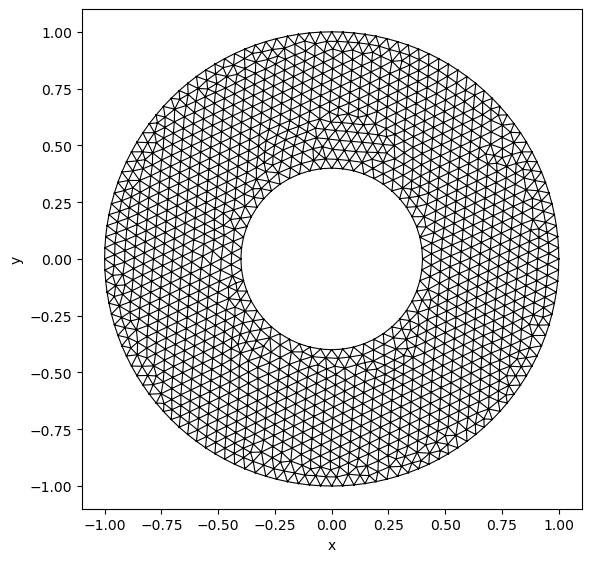

In [5]:
mesh.compute_fvm_geometry()
mesh.plot_topology(
    show_elements=False,
    show_faces=False,
    show_nodes=False,
    element_size = 1,
    face_size = 1,
    node_size = 1,
    figsize = (6, 6)
)

## Problema

In [6]:
p = FVMProblem(mesh)
p.initialize_phi(0.)
p._update_gradients()

In [7]:
def my_gamma(p):
    return np.full(p.Ne, 1.0)
p.gamma_function = my_gamma
p.initialize_gamma()

In [8]:
p.compute_diffusion_coefficients()

## Condiciones de borde

In [9]:
p.create_boundary_patches(boundary_faces)

In [10]:
def my_boundary_sources(p):
    Sc = np.zeros(p.Ne)
    Sp = np.zeros(p.Ne)

    patch = p.left
    gamma = p.Gamma_f[patch.faces]
    coeff = gamma * patch.Sf_norm / patch.dCf_norm
    Sp[patch.cells] += coeff
    Sc[patch.cells] += coeff * 0

    patch = p.right
    gamma = p.Gamma_f[patch.faces]
    coeff = gamma * patch.Sf_norm / patch.dCf_norm
    Sp[patch.cells] += coeff
    Sc[patch.cells] += coeff * 1

    patch = p.down
    gamma = p.Gamma_f[patch.faces]
    coeff = gamma * patch.Sf_norm / patch.dCf_norm
    Sp[patch.cells] += coeff
    Sc[patch.cells] += coeff * 0

    patch = p.up
    gamma = p.Gamma_f[patch.faces]
    coeff = gamma * patch.Sf_norm / patch.dCf_norm
    Sp[patch.cells] += coeff
    Sc[patch.cells] += coeff * 1
    return Sc, Sp

In [11]:
p.boundary_sources_function = my_boundary_sources
p.calculate_boundary_sources()

## Ensamblaje y solución

In [12]:
p.assemble_system()

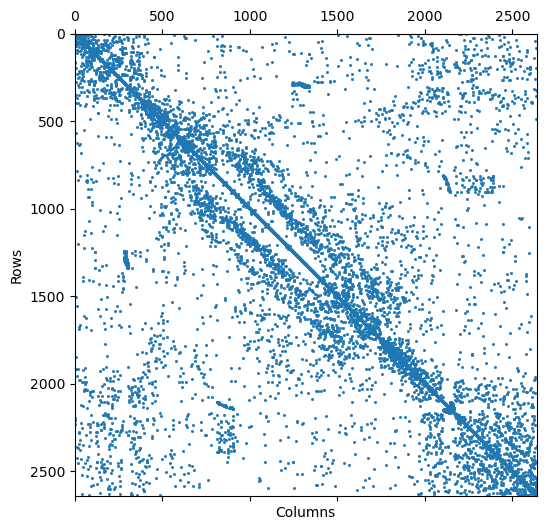

In [13]:
p.plot_matrix_sparsity()

In [14]:
p.solve()

problem solved...


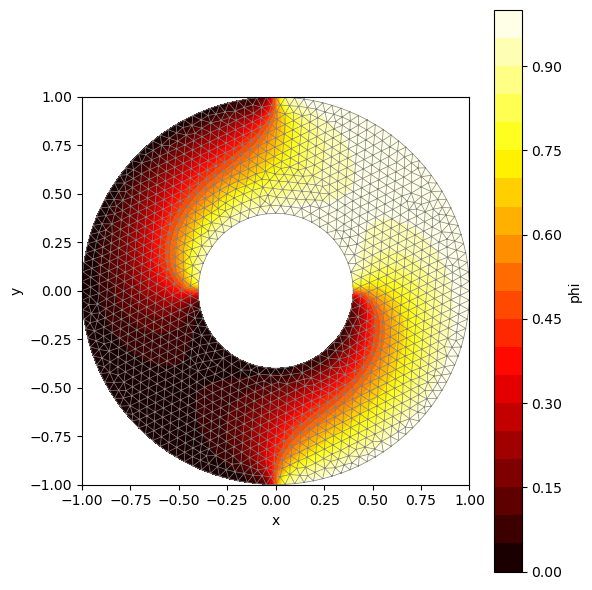

In [16]:
plot_phi_triangulation(p, 
                       show_contour_lines = False,
                      figsize=(6, 6),
                      cmap = "hot",
                      show_mesh=True)